# EfficientNet

In [10]:
import os
import wandb
import pathlib
import tensorflow as tf
import pandas as pd

from bcd.model.repo import ModelRepo
from bcd.model.factory import EfficientNetFactory
from bcd.model.transfer import FineTuner
from bcd.model.callback import Historian
from bcd.model.schedule import LinearThawSchedule, LogThawSchedule, LinearLearningRateSchedule, LogLearningRateSchedule
pd.set_option('display.max_rows',999)


## Configuration

In [11]:
# W&B
%env "WANDB_NOTEBOOK_NAME" "05_efficientnet.ipynb"
project = "breast_cancer_detection"
fine_tune = True

# Model Parameters
full_dataset = True
architecture='EfficientNet'
model_name = "efficient_net" if full_dataset else "efficient_net_10"
version="v2_log"
name = f"{model_name}_{version}"
force = False  # Whether to retrain if the model and weights already exist from a prior training session.
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
base_model_layer = 2 # Layer of the inception resnet base model
base_model_layers = 479 # layers in inception resnet model
loss = "binary_crossentropy"
activation = "sigmoid"

# Dataset params
batch_size = 64 if full_dataset else 32
input_shape = (224,224,3)
output_shape = 1
train_dir = pathlib.Path("data/image/1_final/training/training/").with_suffix('') if full_dataset else pathlib.Path("data/image/1_final/training_10/training/").with_suffix('') 
test_dir = pathlib.Path("data/image/1_final/test/test/").with_suffix('')

# Feature Extraction Parameters
initial_epochs = 100  # Number of epochs to train for feature extraction
fe_learning_rate = 1e-3

# Fine Tune Parameters
fine_tune_epochs = 10  # Number of epochs for each fine tune session
fine_tune_sessions = 5 # Number of fine tune sessions
fine_tune_min_lr = 1e-8
fine_tune_max_lr = 1e-3
fine_tune_thaw_schedule = "log"


# Early stop parameters 
es_min_delta = 0.0001
es_monitor = "val_loss"  # Monitor validation loss for early stopping
es_patience = 8  # The number of consecutive epochs for which lack of improvement is tolerated 
es_restore_best_weights = True  # Returns the best weights rather than the weights at the last epoch.
es_verbose = 1
es_session_patience = None # The number of fine tuning sessions for which lack of improvement is tolerated. If None, no early stopping at session level

# Reduce LR on Plateau Parameters
rlr_monitor = "val_loss"
rlr_factor = 0.5
rlr_patience = 3
rlr_verbose = 1
rlr_mode = "auto"
rlr_min_delta = 0.0001
rlr_min_lr=1e-10

# ModelCheckpoint Callback parameters
mcp_location = "models/"
mcp_mode = "auto"
mcp_save_weights_only = False
mcp_save_best_only = True
mcp_save_freq = "epoch"
mcp_verbose = 1

# Historian parameters
filename = f"{name}_history.pkl"
historian_filepath = os.path.join("models", name, filename)



env: "WANDB_NOTEBOOK_NAME"="05_efficientnet.ipynb"


## Experiment Setup

In [12]:
config = {
    "architecture": architecture,
    "model_name": model_name,
    "version": version,
    "dataset": "CBIS-DDSM",
    "batch_size": batch_size,
    "initial_epochs": initial_epochs,
    "fine_tune": fine_tune,
    "fine_tune_epochs": fine_tune_epochs,
    "fine_tune_sessions": fine_tune_sessions,
    "fine_tune_min_lr": fine_tune_min_lr,
    "fine_tune_max_lr": fine_tune_max_lr,
    "fine_tune_schedule": fine_tune_thaw_schedule,
    "early_stop_min_delta": es_min_delta,
    "early_stop_monitor": es_monitor,
    "early_stop_patience": es_patience,
    "early_stop_restore_best_weights": es_restore_best_weights,
    "early_stop_verbose": es_verbose,
    "rlr_monitor": rlr_monitor,
    "rlr_factor": rlr_factor,
    "rlr_patience": rlr_patience,
    "rlr_verbose": rlr_verbose,
    "rlr_mode": rlr_mode,
    "rlr_min_delta": rlr_min_delta,
    "rlr_min_lr": rlr_min_lr
    
}

In [13]:
run = wandb.init(project=project, config=config)

## Load Data

In [14]:
# Training DataSet (10%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='training',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Validation DataSet (10%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    interpolation="bilinear",
    seed=123,
    batch_size=batch_size)

# Test Set
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    color_mode="rgb",
    image_size=(224,224),
    shuffle=True)

Found 2471 files belonging to 2 classes.
Using 1977 files for training.
Found 2471 files belonging to 2 classes.
Using 494 files for validation.
Found 649 files belonging to 2 classes.


## Dependencies
Several dependencies will be used throughout this notebook, including:
- Early Stop Callback
- Reduce Learning Rate on Plateau Callback
- Model Repository
- ResNet Model Factory
- Historian Callback

We'll make those objects available here.

In [15]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor=es_monitor, 
                                                       min_delta=es_min_delta,
                                                       patience=es_patience, 
                                                       restore_best_weights=es_restore_best_weights,
                                                       verbose=es_verbose)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor=rlr_monitor,
                                                          factor=rlr_factor,
                                                          patience=rlr_patience,
                                                          verbose=rlr_verbose,
                                                          mode=rlr_mode,
                                                          min_delta=rlr_min_delta,
                                                          min_lr=rlr_min_lr)
wandb_callback = wandb.keras.WandbMetricsLogger()

repo = ModelRepo(location=mcp_location)

factory = EfficientNetFactory()

historian = Historian(name=name)

if fine_tune_thaw_schedule == "linear":
    thaw_schedule = LinearThawSchedule(sessions=fine_tune_sessions, 
                                    base_model_layer=base_model_layer, 
                                    n_layers=len(factory.base_model.layers))
    learning_rate_schedule = LinearLearningRateSchedule(sessions=fine_tune_sessions, initial_learning_rate=fine_tune_max_lr, final_learning_rate=fine_tune_min_lr)

else:
    thaw_schedule = LogThawSchedule(sessions=fine_tune_sessions, 
                                   base_model_layer=base_model_layer, 
                                   n_layers=len(factory.base_model.layers))



    learning_rate_schedule = LogLearningRateSchedule(sessions=fine_tune_sessions, initial_learning_rate=fine_tune_max_lr, final_learning_rate=fine_tune_min_lr)


## Feature Extraction
If the model already exists, obtain it from the repository. Otherwise, create the model and perform feature extraction.

In [16]:
stage = "feature_extraction"
if force or not repo.exists(name=name, stage=stage):
    model = factory.create(input_shape=input_shape, 
                            output_shape=output_shape,
                            activation=activation)
    # Create the optimizer
    optimizer=tf.keras.optimizers.Adam(learning_rate=fe_learning_rate)

    # Compile the Model
    model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=metrics,        
    )

    # Delete existing checkpoints
    repo.remove(name=name, stage=stage)
    # Summarize the model
    model.summary()
    # Obtain a checkpoint callback from the model repository 
    checkpoint_callback = repo.create_callback(name=name, stage=stage)
    # Set the session on the historian to 0 for feature extraction
    historian.on_session_begin(session=0)
    # Fit the model with callbacks
    history = model.fit(train_ds, 
                        validation_data=val_ds, 
                        epochs=initial_epochs, 
                        callbacks=[checkpoint_callback, 
                                   reduce_lr_callback,
                                   early_stop_callback, 
                                   wandb_callback,                                   
                                   historian])        
    # Register the model on wandb
    filepath = repo.get_filepath(name=name, stage=stage)    
    artifact = wandb.Artifact(f"{name}-{stage}-{run.id}", type="model")
    artifact.add_file(filepath)
    wandb.log_artifact(artifact, aliases=[stage, "best"])
    wandb.run.link_artifact(artifact, "aistudio/breast_cancer_detection/InceptionResnet")
else:
    # Obtain the model from the repository
    model = repo.get(name=name, stage=stage)
    # Obtain the historian
    historian = historian.load(historian_filepath)    
    # Summarize the model
    model.summary()

INFO:ModelRepo:Loaded efficient_net_v2_log_feature_extraction model from the repository.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)

## Fine Tuning

In [17]:
if fine_tune:
    ft = FineTuner(name=name, 
                train_ds=train_ds, 
                validation_ds=val_ds, 
                repo=repo,
                thaw_schedule=thaw_schedule,
                learning_rate_schedule=learning_rate_schedule,               
                metrics=metrics,
                fine_tune_epochs=fine_tune_epochs,
                sessions=fine_tune_sessions,
                callbacks=[early_stop_callback, reduce_lr_callback, wandb_callback],
                )
    ft.tune(model=model, historian=historian, force=force)
run.finish()



INFO:LogThawSchedule:Thawed 2 layers of the base model.


INFO:LogLearningRateSchedule:Set learning rate to 0.001
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             


                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 20,332,641
Trainable params: 3,841
Non-trainable params: 20,328,800
_________________________________________________________________
Epoch 35/44
31/31 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.6859 - precision_1: 0.6767 - recall_1: 0.5787
Epoch 35: val_loss improved from inf to 0.63836, saving model to models/efficient_net_v2_log/fine_tuning_session_1/efficie

wandb: Waiting for artifact efficient_net_v2_log-fine_tuning_session_1-a9im0leb to be committed...



wandb: Committed artifact aistudio/breast_cancer_detection/efficient_net_v2_log-fine_tuning_session_1-a9im0leb:v0




INFO:LogThawSchedule:Thawed 7 layers of the base model.


INFO:LogLearningRateSchedule:Set learning rate to 5.623413251903491e-05
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-s (Functiona  (None, None, None, 1280)  20331360 
 l)                                                              
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                             

## Learning Curves

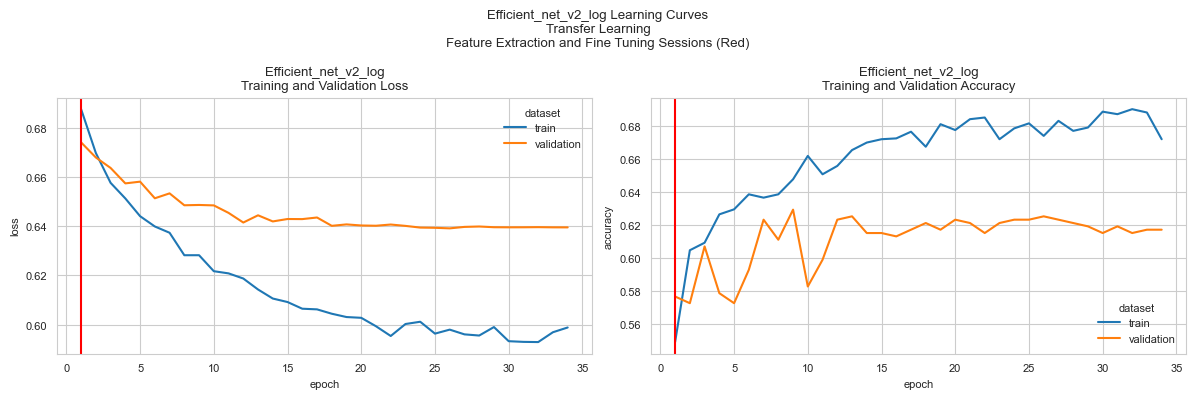

In [ ]:
# Plot the historian
historian.plot_learning_curves()

## Evaluation